Importing all the libraries

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import poisson, norm
import matplotlib.pyplot as plt
from collections import Counter, defaultdict

## Question 1

In [2]:
files = {
    "E. coli (K12)": "ecoli.chrom.sizes",
    "Yeast (sacCer3)": "yeast.chrom.sizes",
    "Worm (ce10)": "ce10.chrom.sizes",
    "Fruit Fly (dm6)": "dm6.chrom.sizes",
    "Arabidopsis (TAIR10)": "TAIR10.chrom.sizes",
    "Tomato (SL v4.00)": "tomato.chrom.sizes",
    "Human (hg38)": "hg38.chrom.sizes",
    "Wheat (IWGSC)": "wheat.chrom.sizes"
}

In [3]:
results = []

for species, filename in files.items():
    df = pd.read_csv(filename, sep="\t", header=None, names=["chrom", "size"])
    
    total_size = df["size"].sum()
    n_chroms = len(df)
    largest_chrom = df.loc[df["size"].idxmax()]
    smallest_chrom = df.loc[df["size"].idxmin()]
    mean_size = total_size / n_chroms
    
    results.append({
        "Species": species,
        "Total Genome Size (bp)": total_size,
        "Num Chromosomes": n_chroms,
        "Largest Chromosome": f"{largest_chrom['chrom']} ({largest_chrom['size']})",
        "Smallest Chromosome": f"{smallest_chrom['chrom']} ({smallest_chrom['size']})",
        "Mean Chromosome Size (bp)": round(mean_size, 2)
    })

results_df = pd.DataFrame(results)

In [4]:
results_df

,Species,Total Genome Size (bp),Num Chromosomes,Largest Chromosome,Smallest Chromosome,Mean Chromosome Size (bp)
0,E. coli (K12),4639211,1,Ecoli (4639211),Ecoli (4639211),4.639211e+06
1,Yeast (sacCer3),12157105,17,chrIV (1531933),chrM (85779),7.151238e+05
2,Worm (ce10),100286070,7,chrV (20924149),chrM (13794),1.432658e+07
3,Fruit Fly (dm6),137547960,7,chr3R (32079331),chr4 (1348131),1.964971e+07
4,Arabidopsis (TAIR10),119146348,5,Chr1 (30427671),Chr4 (18585056),2.382927e+07
5,Tomato (SL v4.00),782520033,13,ch01 (90863682),ch00 (9643250),6.019385e+07
6,Human (hg38),3088269832,24,chr1 (248956422),chr21 (46709983),1.286779e+08
7,Wheat (IWGSC),14547261565,22,3B (830829764),6D (473592718),6.612392e+08


In [5]:
print(results_df.to_string(index=True))

                Species  Total Genome Size (bp)  Num Chromosomes Largest Chromosome Smallest Chromosome  Mean Chromosome Size (bp)
0         E. coli (K12)                 4639211                1    Ecoli (4639211)     Ecoli (4639211)               4.639211e+06
1       Yeast (sacCer3)                12157105               17    chrIV (1531933)        chrM (85779)               7.151238e+05
2           Worm (ce10)               100286070                7    chrV (20924149)        chrM (13794)               1.432658e+07
3       Fruit Fly (dm6)               137547960                7   chr3R (32079331)      chr4 (1348131)               1.964971e+07
4  Arabidopsis (TAIR10)               119146348                5    Chr1 (30427671)     Chr4 (18585056)               2.382927e+07
5     Tomato (SL v4.00)               782520033               13   ch01  (90863682)      ch00 (9643250)               6.019385e+07
6          Human (hg38)              3088269832               24   chr1 (248956422)

## Question 2

##### Question 2.1. How many 100bp reads are needed to sequence a 1Mbp genome to 3x coverage?

##### 2.1: Coverage (C) = N * L / G, here C=3, G=1000000bp , L=100bp. Therefore:

In [16]:
C=3
G=1000000
L=100
N=(C*G)/L
print(f"Number of reads (N) needed: {N}")

Number of reads (N) needed: 30000.0


##### Question 2.2

In [17]:
genomesize = 1000000
readlength = 100
coverage = 3

In [18]:
def calculate_number_of_reads(genomesize, readlength, coverage):
    return (coverage * genomesize) // readlength

In [24]:
def coverage_dist(genomesize, readlength, coverage, poisson_lambda, normal_mean, normal_std):
    num_reads = calculate_number_of_reads(genomesize, readlength, coverage)
    genome_coverage = np.zeros(genomesize, dtype=int)

    for _ in range(num_reads):
        startpos = np.random.randint(0, genomesize - readlength + 1)  # inclusive start
        genome_coverage[startpos:startpos + readlength] += 1
    
    maxcoverage = genome_coverage.max()
    histogram = np.zeros(maxcoverage + 1, dtype=int)

    for cov in genome_coverage:
        histogram[cov] += 1
    hist_freq = histogram / genomesize
    x_vals = np.arange(len(hist_freq))
    plt.bar(x_vals, hist_freq, width=1.0, alpha=0.6, label="Simulated coverage")
    plt.plot(x_vals, poisson.pmf(x_vals, mu=poisson_lambda), 'r-', lw=1, label=f"Poisson(λ={poisson_lambda})")
    x_cont = np.linspace(0, maxcoverage, 200)
    plt.plot(x_cont, norm.pdf(x_cont, loc=normal_mean, scale=normal_std), 'g--', lw=2, label=f"Normal(μ={normal_mean}, σ≈{normal_std})")
    plt.xlabel("Coverage depth")
    plt.ylabel("Fraction of bases")
    plt.title("Simulated sequencing coverage (3×, 100 bp reads, 1 Mbp genome)")
    plt.legend()
    plt.show()

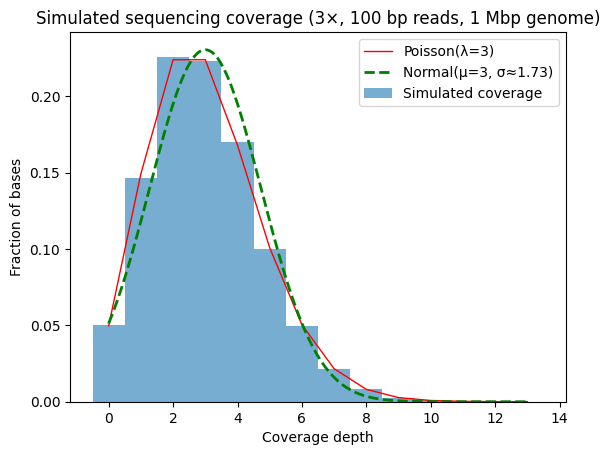

In [25]:
coverage_dist(genomesize=1_000_000, readlength=100, coverage=3, poisson_lambda=3, normal_mean=3, normal_std=1.73)

Question 2.3. Using the histogram from Q2.2, how much of the genome has not been sequenced (has 0x coverage)? How well does this match Poisson expectations? How well does the normal distribution fit the data?

Answer: Approximately 5% of the genome has not been sequenced, as shown by the height of the first bar in the histogram. This matches the Poisson expectation for a mean coverage of 3 (λ=3), where the probability of zero coverage is about 4.98%. The Poisson distribution fits the simulated data very well, both for 0x coverage and across the entire range. In contrast, the normal distribution provides a rough approximation near the mean coverage but does not fit the data as well, as it is a centered a little to the right of the histogram.

Question 2.4. Now repeat the analysis with 10x coverage: 1. simulate the appropriate number of reads, 2. make a histogram, 3. overlay a Poisson distribution with lambda=10, 4. overlay with a Normal distribution with mean=10, standard deviation=3.16. 5. compute the number of bases with 0x coverage, and 6. evaluate how well it matches the Poisson expectation and Normal expectations.

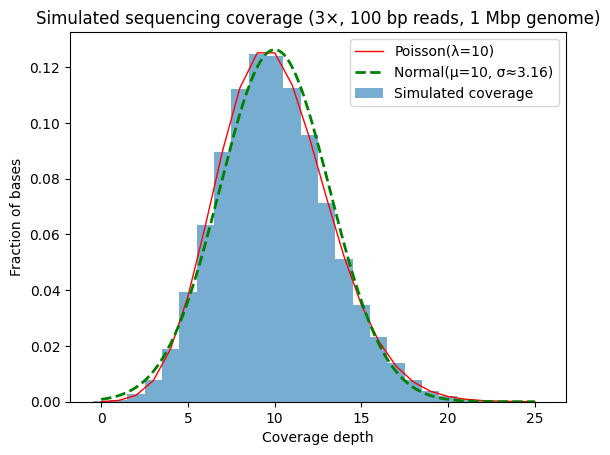

In [26]:
coverage_dist(genomesize=1_000_000, readlength=100, coverage=10, poisson_lambda=10, normal_mean=10, normal_std=3.16)

**Answer:** With 10x coverage, the histogram shows that almost none of the genome has 0x coverage:the first bar at coverage depth 0 is essentially flat at zero. This matches the Poisson expectation for λ=10, where the probability of zero coverage is e^(-10) or about 0.0045%,far below what is visually distinguishable in the histogram. The Poisson distribution with λ=10 (red line) fits the simulated data very well across all coverage depths. In this case, the normal distribution (mean=10, σ=3.16) also provides a good approximation to the shape of the distribution, especially near the center, because the Poisson distribution with larger λ becomes more symmetric and bell-shaped. However, the normal still predicts non-zero probability for negative coverage, and slightly deviates at the lowest coverage values, but overall the fit is much better than at low coverage.

Question 2.5. Now repeat the analysis with 30x coverage: 1. simulate the appropriate number of reads, 2. make a histogram, 3. overlay a Poisson distribution with lambda=30, 4. overlay with a Normal distribution with mean=30, standard deviation=5.47 5. compute the number of bases with 0x coverage, and 6. evaluate how well it matches the Poisson expectation and Normal expectations.

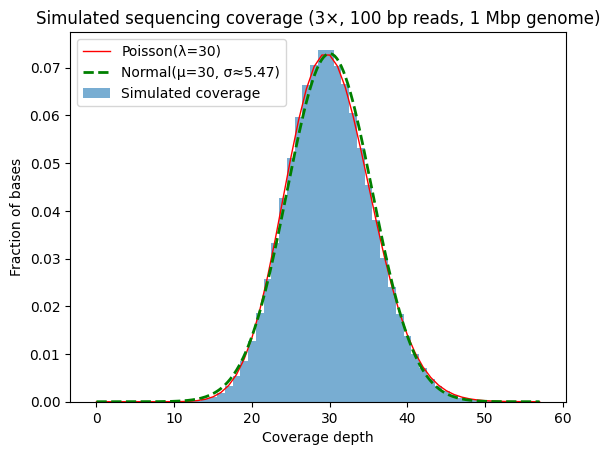

In [27]:
coverage_dist(genomesize=1_000_000, readlength=100, coverage=30, poisson_lambda=30, normal_mean=30, normal_std=5.47)

**Answer:** At 30x coverage, the histogram shows that virtually none of the genome has 0x coverage; there is no visible bar at zero. This matches the Poisson expectation for λ=30, where the probability of zero coverage is e^(-30), which is effectively zero. Both the Poisson distribution (red line) and the normal distribution (mean=30, σ=5.47, green line) fit the simulated data extremely well, with both curves nearly indistinguishable from the histogram. At this high coverage, the Poisson and normal distributions have very similar bell shapes, and the normal approximation is excellent throughout the entire distribution.

## Question 3

Question 3.1. How many As, Cs, Gs, Ts and Ns are found in the entire chromosome? If needed convert lowercase letters to uppercase, and any other character can be converted to N.

In [28]:
from collections import Counter

def read_genome(file_path):
    with open(file_path, 'r') as f:
        genome = ""
        for line in f:
            if line.startswith(">"):
                continue 
            genome += line.strip().upper()
        return genome
genome_string = read_genome("chr22.fa")
genome_string = ''.join([base if base in 'ACGT' else 'N' for base in genome_string])
base_counts = Counter(genome_string)
print("Base counts:")
for base in ['A', 'C', 'G', 'T', 'N']:
    print(f"{base}: {base_counts.get(base, 0)}")


Base counts:
A: 10382214
C: 9160652
G: 9246186
T: 10370725
N: 11658691


Question 3.2. In the language of your choice, tally the frequency of 19-mers in the chromosome, and output the kmer frequency spectrum upto 1000 e.g. how many kmers occur 1 time, how many occur 2 times, how many occur 3 times, etc. For this, convert lowercase letters to uppercase, and any character that is not ACG or T can be converted to A (especially N characters). We recommend you use a dictionary (or hash table) to tally the frequencies using this pseudocode. In your writeup, show the kmer frequency spectrum for 1 to 20, e.g. how many kmers occur 1 time, how many occur 2, ..., how many occur 20 times. This can be done with the unix command 

Question 3.3. Using the output from 3.2, plot the kmer frequency spectrum: x-axis is the kmer frequency, and the y-axis is the number of kmers that occur x times. Make sure to plot both the x and y-axis in log space.

Question 3.4. a) What percent of the genome is unique, e.g. what percent of the kmers occur 1 time. b) What percent of the genome is repetitive (occurs more than 1 time). c) What percent occurs more than 1000 times?

Frequency Spectrum (1–20):
1	29427206
2	989881
3	264956
4	123283
5	57183
6	32997
7	23784
8	17021
9	13268
10	10842
11	9082
12	7525
13	6495
14	5728
15	4828
16	4392
17	3980
18	3463
19	3094
20	2805


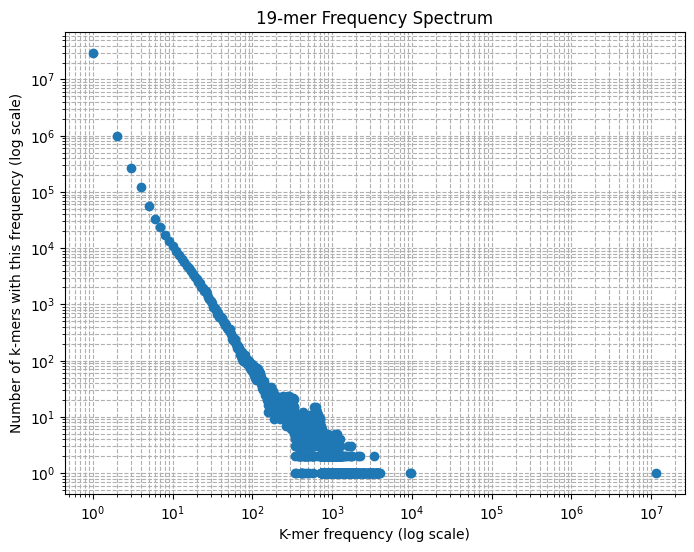


Percentages:
Unique kmers: 57.91%
Repetitive kmers (>1 occurrence): 42.09%
Kmers occurring >1000 times: 24.44%


In [15]:
genome_length = len(genome_string)
k=19

kmer_counts = defaultdict(int)
for i in range(genome_length - k + 1):
    kmer = genome_string[i:i+k]
    kmer_counts[kmer] += 1

freq_tally = Counter(kmer_counts.values())
max_freq = max(freq_tally.keys())

print("Frequency Spectrum (1–20):")
for i in range(1, 21):
    print(f"{i}\t{freq_tally.get(i, 0)}")

x = sorted(freq_tally.keys())
y = [freq_tally[f] for f in x]

plt.figure(figsize=(8,6))
plt.loglog(x, y, marker='o', linestyle='none')
plt.xlabel("K-mer frequency (log scale)")
plt.ylabel("Number of k-mers with this frequency (log scale)")
plt.title(f"{k}-mer Frequency Spectrum")
plt.grid(True, which="both", ls="--")
plt.show()

total_kmers = genome_length - k + 1
unique_kmers_count = freq_tally.get(1, 0)

repetitive_kmers_count = total_kmers - unique_kmers_count

highly_repetitive_count = sum(freq * count for freq, count in freq_tally.items() if freq > 1000)

unique_pct = (unique_kmers_count / total_kmers) * 100
repetitive_pct = (repetitive_kmers_count / total_kmers) * 100
highly_repetitive_pct = (highly_repetitive_count / total_kmers) * 100

print("\nPercentages:")
print(f"Unique kmers: {unique_pct:.2f}%")
print(f"Repetitive kmers (>1 occurrence): {repetitive_pct:.2f}%")
print(f"Kmers occurring >1000 times: {highly_repetitive_pct:.2f}%")

## Question 4

Question 4.1. Use ChatGPT (or your favorite LLM) to write an essay on why you are interested in genomics. Make sure to ask for references. Make sure to include both your prompt(s) and the output from the LLM

**LLM** : GPT-5 <br><br>
**Prompt:** Write an essay in about 500 words about why I am interested in genomics: Make sure to include the following points.<br>I am a MS CS student at JHU. <br>JHU is known for it s research into medical domain. <br>I have already done machine learning projects in this domain. <br>I wanted to take a class which was combining both CS and biology <br>Thought genomics was cool and wanted to learn more about it (I dont know anything about genomics)<br><br>
**Response:** As a Master’s student in Computer Science at Johns Hopkins University (JHU), I have always been fascinated by the intersection of technology and medicine. JHU’s reputation as a global leader in medical research was one of the reasons I was drawn to the university, and it has continually inspired me to explore opportunities where my background in computer science can be applied to solve impactful problems in healthcare. Over the course of my academic journey, I have developed a strong interest in machine learning and have had the opportunity to work on several projects in the medical domain. These experiences have given me a glimpse into how computational techniques can revolutionize patient care, diagnostics, and treatment planning, and have fueled my desire to dive deeper into fields that merge computing with biological sciences.<br>
While I have primarily worked on the computer science side of these projects, I have always been curious about the biological and medical concepts driving the data I analyze. This curiosity motivated me to look for courses that would bridge the gap between my computational expertise and the world of biology. When I came across genomics, I immediately thought it was an exciting opportunity to learn more about a field that is fundamentally shaping modern medicine. Genomics stood out to me as a domain that not only embodies this interdisciplinary spirit but also has the potential to redefine how we understand and treat disease.<br>
I will admit that I entered this course without any formal background in genomics. However, that was precisely what made it so appealing: I wanted to challenge myself and step outside my comfort zone to gain knowledge in a completely new discipline. I found the idea of decoding and analyzing the blueprint of life itself—DNA—to be fascinating, especially when combined with computational tools that can process vast amounts of genetic data. As someone deeply interested in machine learning, I was excited to see how algorithms and computational methods could be applied to solve problems in this area, from identifying genetic markers for disease to improving personalized medicine.
My previous machine learning projects in the medical domain provided a strong foundation for this interest. These experiences taught me the power of data-driven approaches in healthcare, but they also revealed that the medical field is full of rich, complex datasets—like genomic sequences—that require specialized knowledge to interpret effectively. By studying genomics, I hope to bridge this gap and equip myself with the tools to apply computer science expertise in an area with incredible potential to advance medicine.<br>
Ultimately, my interest in genomics stems from a desire to explore a field that lies at the cutting edge of both computer science and biology. JHU’s unique strengths in medical research, combined with my computational background and passion for learning, make this an ideal environment for me to grow. I am excited by the prospect of contributing to a field where technology can help unlock deeper understanding of biology and transform the future of healthcare.<br>



Question 4.2. Comment on the output from the LLM - does it make logical sense, does it include any phrases you would not have written, do the cited papers exist and support the claims from the LLM?

The output from the LLM does make logical sense but it does tend to hallucinate a lot. It is adding a lot of points which I have not mentioned instead of building upon my own. For example: "These experiences have given me a glimpse into how computational techniques can revolutionize patient care, diagnostics, and treatment planning, and have fueled my desire to dive deeper into fields that merge computing with biological sciences.". The essay is well written but it can be easily detected by a person who has worked with these models before.

Question 4.3 Post your final prompt, the LLM's response, and which LLM you used to piazza. Include the link to the post in your submission

Link: https://piazza.com/class/meogfdbmu7x7hf/post/11_f28